In [399]:
%matplotlib inline
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [398]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib.animation as ani

AttributeError: 'Line2D' object has no attribute 'xdata'

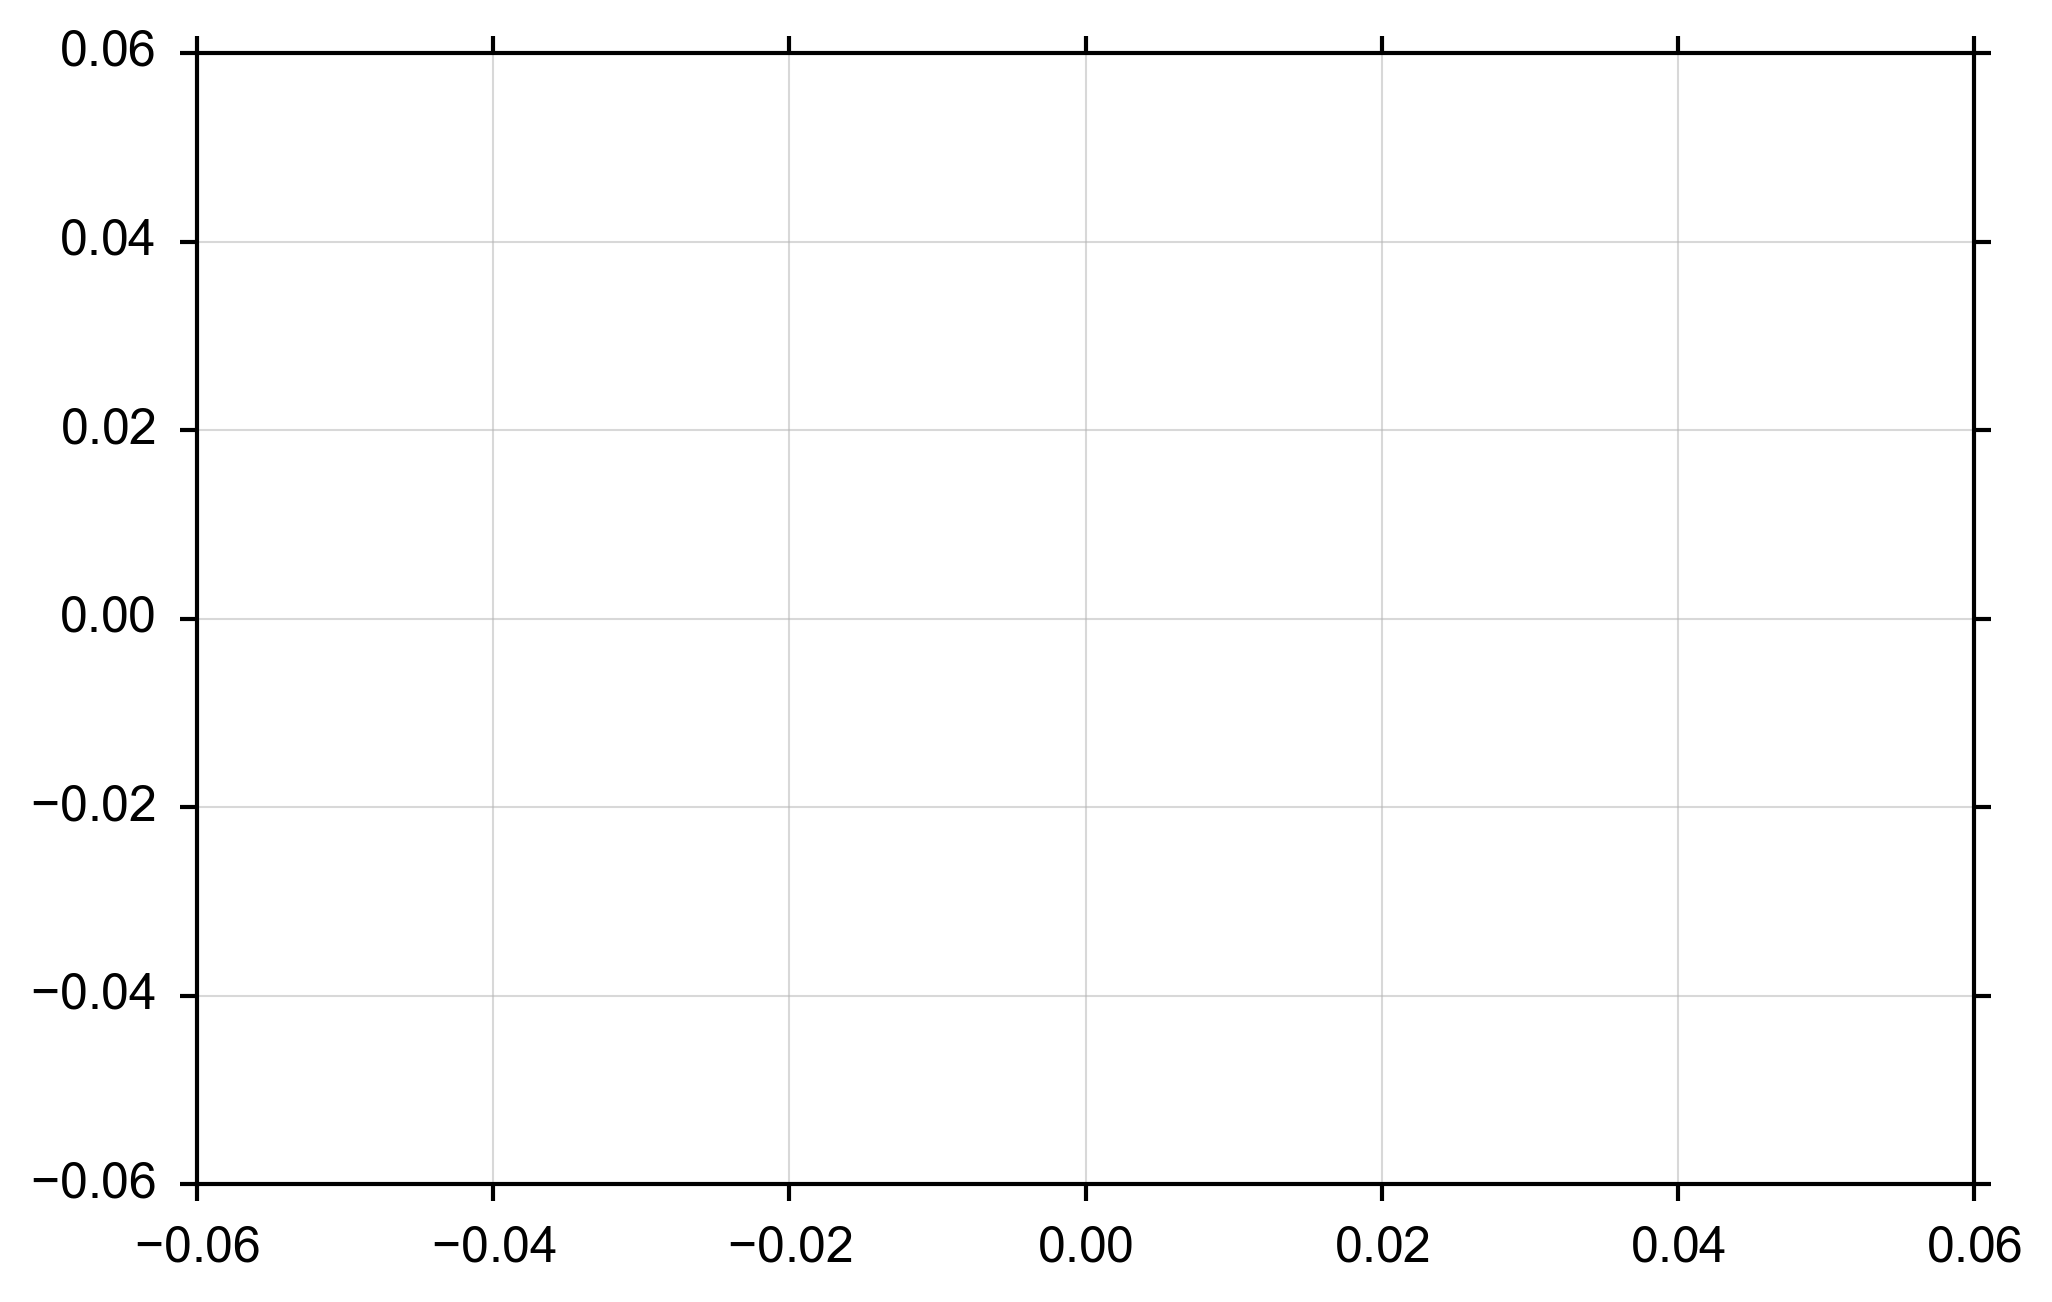

In [438]:
ax = plt.axes()
print ax.plot([], [], lw=2)
line, = ax.plot([],[])
print line

[[<matplotlib.lines.Line2D object at 0x10d155d90>], [<matplotlib.lines.Line2D object at 0x10d1551d0>], [<matplotlib.lines.Line2D object at 0x10cb47050>]]


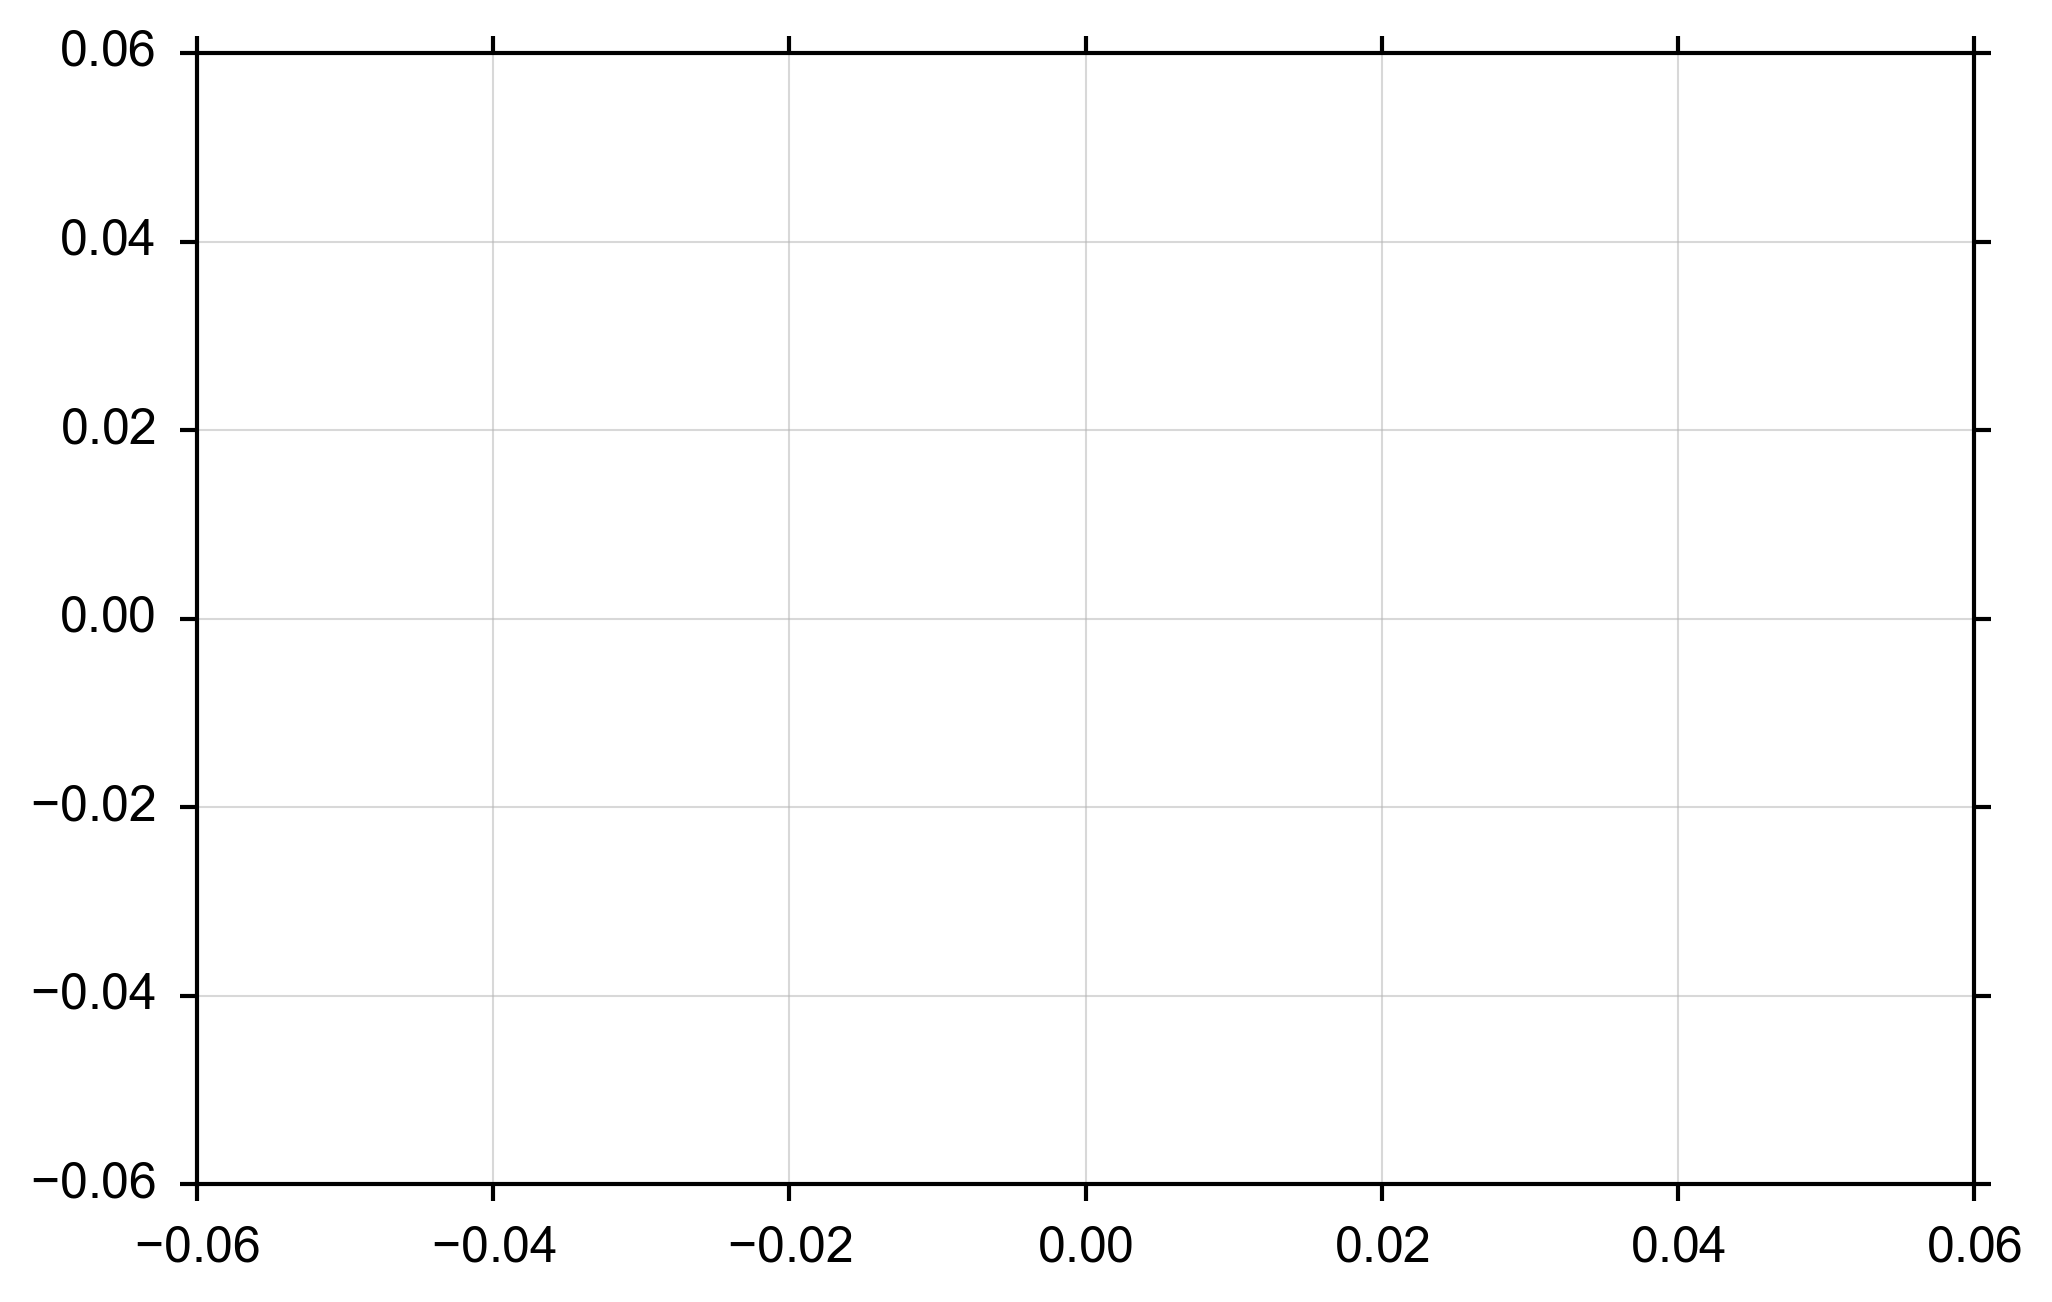

In [460]:
fig = plt.figure()
ax = plt.axes()
lines = [ax.plot([],[]) for t in trajectories]
print lines
def animate_trajectories(trajectories,i,lines=[ax.plot([],[]) for t in trajectories]):
    for t in range(len(trajectories)):
        lines[t] = lines[t][0]
        lines[t].set_data(trajectories[t,i,0],trajectories[t,i,1])
    return lines
animate_trajectories(trajectories,i) 

In [458]:
animate_trajectories(trajectories,1)

In [484]:
def mag(v):
    s = 0
    for i in v:
        s += i**2
    return np.sqrt(s)

class particle(object):
    
    def __init__(self,r0 = np.zeros(2),v0 = np.zeros(2), a0=np.zeros(2)):
        self.r = r0
        self.v = v0
        self.a = a0

class container(object):
    
    xBound = np.array([-10,10])
    yBound = np.array([-10,10])
    
    def __init__(self, kT = 1):
        self.kT = kT
    
    def velocity(self):
        vx = np.random.normal(loc=0, scale=self.kT)
        vy = np.random.normal(loc=0, scale=self.kT)
        return np.array([vx,vy])
    
class simulation(object):
    
    def __init__(self,particles, container, tmax, dt):
        self.trajectories = np.zeros((len(particles),np.floor(tmax/dt),6))
        self.particles = particles
        self.container = container
        self.tmax = tmax
        self.dt = dt
    
    def check_bounds(self,p):
        if p.r[0] < self.container.xBound[0] or p.r[0] > self.container.xBound[1]:
            return [True,False]
        elif p.r[1] < self.container.yBound[0] or p.r[1] > self.container.yBound[1]:
            return [False,True]
        else:
            return [False,False]
    
    def runSimulation(self):
        for i,t in enumerate(np.arange(0,self.tmax,self.dt)):
            for j in range(len(particles)):
                self.trajectories[j,i] = [self.particles[j].r[0],self.particles[j].r[1],
                                          self.particles[j].v[0],self.particles[j].v[1],0,0]
                self.particles[j].r += self.particles[j].v*self.dt
                check = self.check_bounds(self.particles[j])
                for k in [0,1]:
                    if check[k]:
                        self.particles[j].v[k] = -1 * self.particles[j].v[k]
        
        return self.trajectories
    
    def runConstantForce(self):
        for i,t in enumerate(np.arange(0,self.tmax,self.dt)):
            for j in range(len(self.particles)):
                self.trajectories[j,i] = [self.particles[j].r[0],self.particles[j].r[1],
                                          self.particles[j].v[0],self.particles[j].v[1],
                                          self.particles[j].a[0],self.particles[j].a[1]]
                self.particles[j].r += self.particles[j].v*self.dt + 0.5 * self.particles[j].a*self.dt**2
                self.particles[j].v += self.particles[j].a*self.dt
                self.particles[j].a = np.array([0,-1]) 
                check = self.check_bounds(self.particles[j])
                for k in [0,1]:
                    if check[k]:
                        self.particles[j].v[k] = -0.5 * self.particles[j].v[k]
        return self.trajectories
    
    def runHarmonic(self,k):
        for i,t in enumerate(np.arange(0,self.tmax,self.dt)):
            for j in range(len(self.particles)):
                self.trajectories[j,i] = [self.particles[j].r[0],self.particles[j].r[1],
                                          self.particles[j].v[0],self.particles[j].v[1],
                                          self.particles[j].a[0],self.particles[j].a[1]]
                self.particles[j].r += self.particles[j].v*self.dt + 0.5 * self.particles[j].a*self.dt**2
                self.particles[j].v += self.particles[j].a*self.dt
                self.particles[j].a = -k*self.particles[j].r
                check = self.check_bounds(self.particles[j])
                for q in [0,1]:
                    if check[q]:
                        self.particles[j].v[q] = -1 * self.particles[j].v[q]
        return self.trajectories
    
    def runExcludedVolume(self,size=0.1,externalField = None):
        particles = self.particles
        c = self.container
        for i,t in enumerate(np.arange(0,self.tmax,self.dt)):
            for j in range(len(particles)):
                for k in range(len(particles)):
                    if j != k:
                        if mag(particles[k].r-particles[j].r) < size:
                            particles[j].v = c.velocity()
                            particles[k].v = c.velocity()
                self.trajectories[j,i] = [particles[j].r[0],particles[j].r[1],
                                          particles[j].v[0],particles[j].v[1],
                                          particles[j].a[0],particles[j].a[1]]
                particles[j].r += particles[j].v*self.dt + 0.5 * particles[j].a*self.dt**2
                particles[j].v += particles[j].a*self.dt
                if externalField is not None:
                    partilces[j].a = externalField(particles[j].r)
                check = self.check_bounds(particles[j])
                for q in [0,1]:
                    if check[q]:
                        particles[j].v[q] = -1 * particles[j].v[q]
        return self.trajectories
                        

In [495]:
numParticles = 30
c = container(kT = 1)
ps = [ particle(r0=3*np.random.randn(2),v0=c.velocity())
      for i in range(numParticles) ]
sim = simulation(ps,c,100,0.01)
trajectories = sim.runConstantForce()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


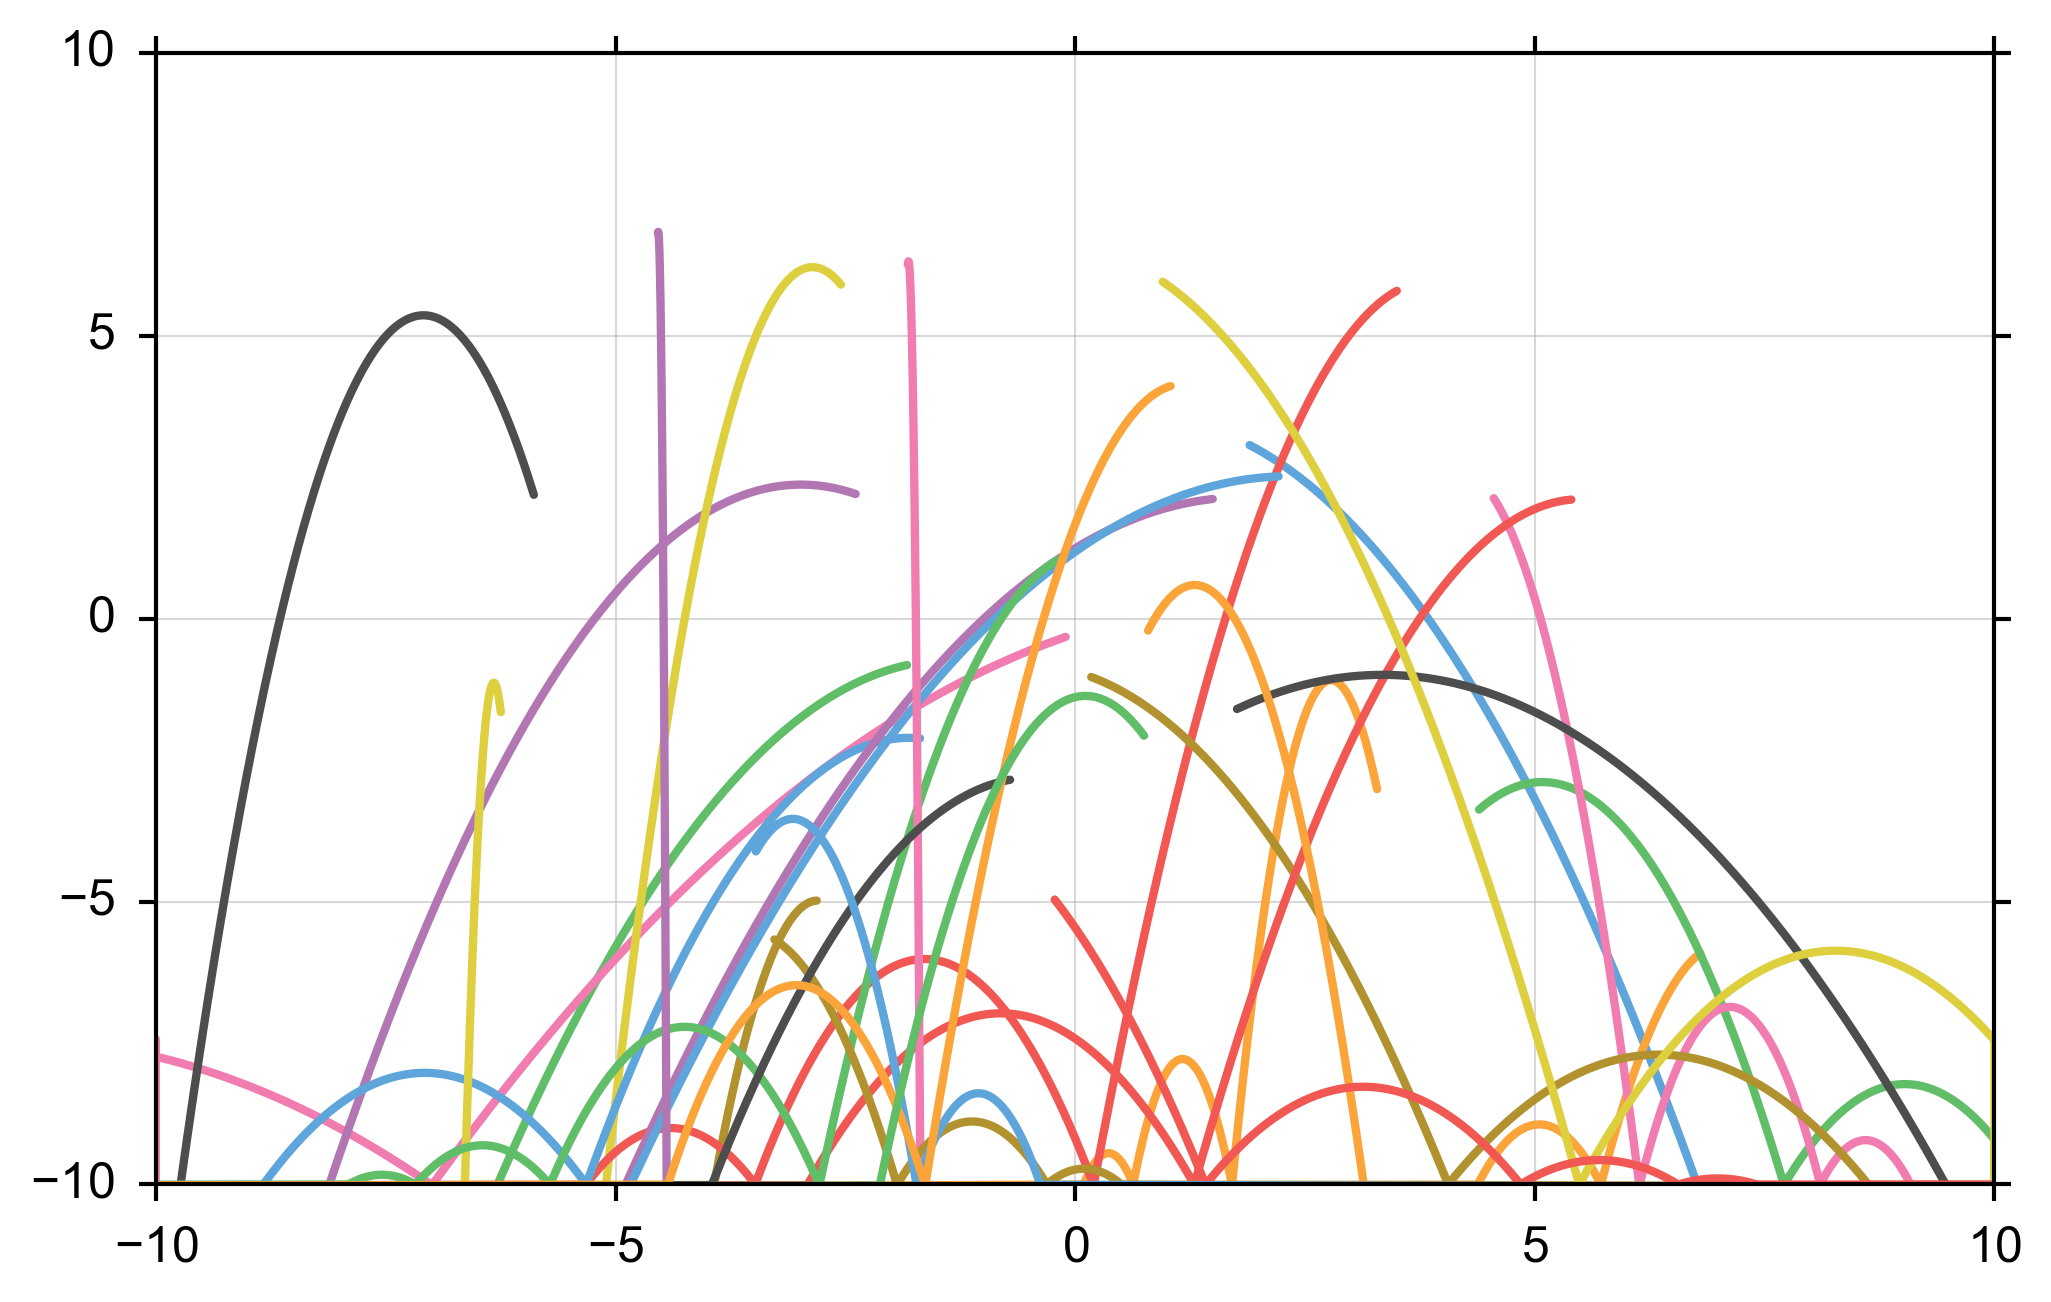

In [496]:
for i in range(numParticles):
    plt.plot(trajectories[i,:,0],trajectories[i,:,1])
plt.xlim(-10,10);
plt.ylim(-10,10);

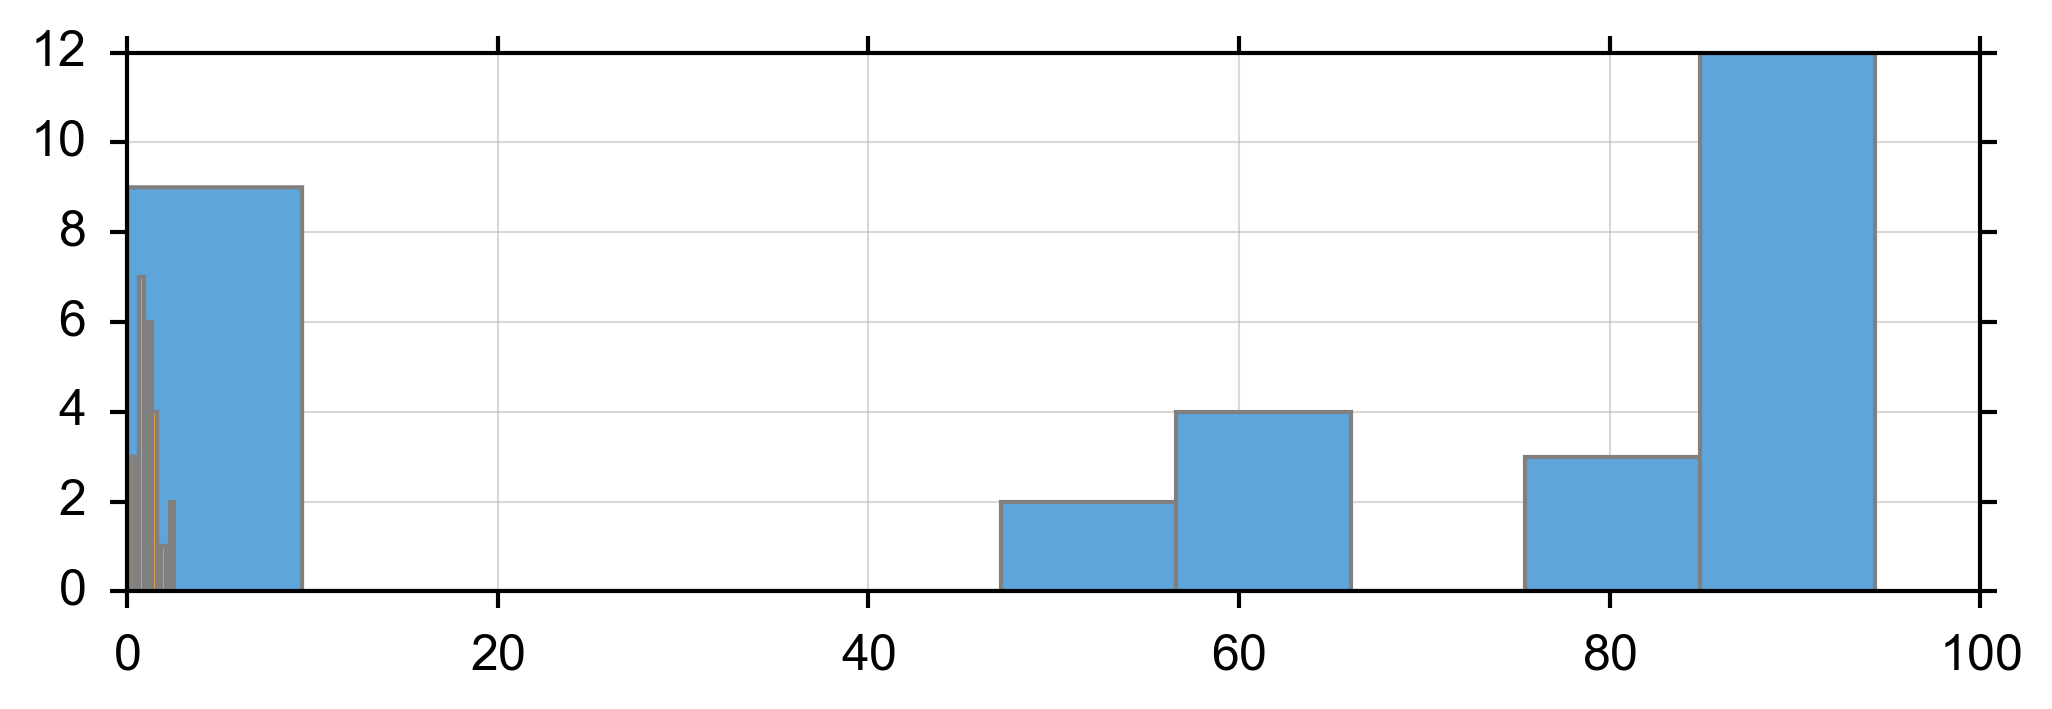

In [497]:
plt.subplot(2,1,1)
plt.hist(np.sqrt((trajectories[:,-1,2]**2+trajectories[:,-1,3]**2)));
plt.hist(np.sqrt((trajectories[:,0,2]**2+trajectories[:,0,3]**2)));